In [39]:
#import all necessary libraries
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import matplotlib
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model

from scipy import stats
import seaborn as sns
sns.set_style('whitegrid')

from datetime import datetime
import yfinance as yf

from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input
from tensorflow.keras.models import Sequential, load_model
import tensorflow.keras.backend as k
from tensorflow.keras.losses import MeanAbsoluteError
#from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [40]:
stock_symbol = 'AAPL'
data = yf.download(tickers = stock_symbol, period = '5y', interval= '1d')
data.head

[*********************100%%**********************]  1 of 1 completed


<bound method NDFrame.head of                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2019-08-21   53.247501   53.412498   52.900002   53.160000   51.439957   
2019-08-22   53.297501   53.610001   52.687500   53.115002   51.396416   
2019-08-23   52.357498   53.012501   50.250000   50.660000   49.020855   
2019-08-26   51.465000   51.797501   51.264999   51.622501   49.952209   
2019-08-27   51.965000   52.137501   50.882500   51.040001   49.388561   
...                ...         ...         ...         ...         ...   
2024-08-14  220.570007  223.029999  219.699997  221.720001  221.720001   
2024-08-15  224.600006  225.350006  222.759995  224.720001  224.720001   
2024-08-16  223.919998  226.830002  223.649994  226.050003  226.050003   
2024-08-19  225.720001  225.990005  223.039993  225.889999  225.889999   
2024-08-20  225.770004  227.169998  225.449997  226.509995  226.509995   

       

In [41]:
len(data)

1258

In [42]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-08-14,220.570007,223.029999,219.699997,221.720001,221.720001,41960600
2024-08-15,224.600006,225.350006,222.759995,224.720001,224.720001,46414000
2024-08-16,223.919998,226.830002,223.649994,226.050003,226.050003,44340200
2024-08-19,225.720001,225.990005,223.039993,225.889999,225.889999,40687800
2024-08-20,225.770004,227.169998,225.449997,226.509995,226.509995,29914893


In [43]:
opn = data[['Open']]

<Axes: xlabel='Date'>

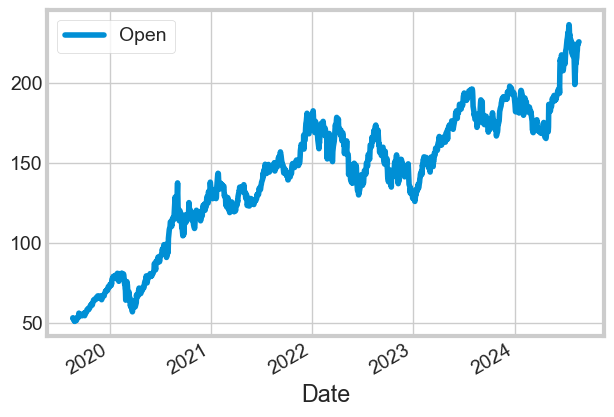

In [44]:
opn.plot()

In [45]:
ds = opn.values

In [46]:
ds

array([[ 53.24750137],
       [ 53.29750061],
       [ 52.35749817],
       ...,
       [223.91999817],
       [225.72000122],
       [225.77000427]])

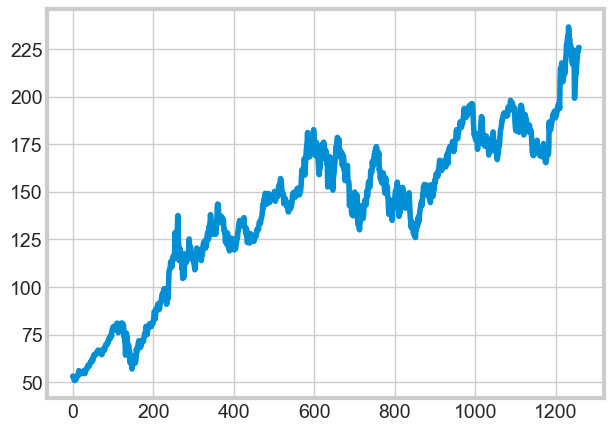

In [47]:
plt.plot(ds)

In [48]:
normalizer = MinMaxScaler(feature_range=(0, 1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [49]:
train_size = int(len(ds_scaled) * 0.7)
test_size = len(ds_scaled) - train_size
train_size, test_size

(880, 378)

In [50]:
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:]
len(ds_train), len(ds_test)

(880, 378)

In [51]:
def create_ds(dataset, step):
    X_train, Y_train = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:i+step, 0]
        X_train.append(a)
        Y_train.append(dataset[i+step, 0])
    return np.array(X_train), np.array(Y_train)

In [52]:
time_stamp = 100
X_train, Y_train = create_ds(ds_train, time_stamp)
X_test, Y_test = create_ds(ds_test, time_stamp)

In [53]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [56]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1],1)))
model.add(LSTM(128, return_sequences = True, activation = 'relu'))
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

C:\Users\tabas\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                  │ (None, 100, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 100, 50)        │        35,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,811 (557.86 KB)

 Trainable params: 142,811 (557.86 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, validation_data =(X_test, Y_test), epochs=100, batch_size=64)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 377ms/step - loss: 0.1222 - val_loss: 0.0842
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 303ms/step - loss: 0.0151 - val_loss: 0.0105
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 276ms/step - loss: 0.0066 - val_loss: 0.0046
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 280ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 387ms/step - loss: 0.0022 - val_loss: 0.0051
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 349ms/step - loss: 0.0022 - val_loss: 0.0052
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 352ms/step - loss: 0.0022 - val_loss: 0.0035
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 311ms/step - loss: 0.0020 - val_loss: 0.0057
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 339ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 319ms/step - loss: 0.0019 - val_loss: 0.0043
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 332ms/step - loss: 0.0017 - val_loss: 0.0036
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 

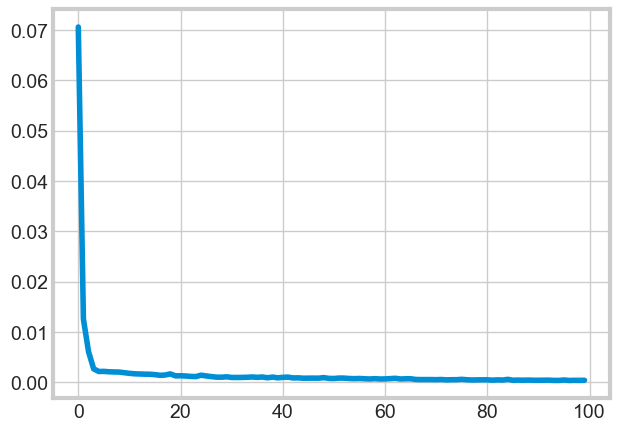

In [59]:
loss = model.history.history['loss']
plt.plot(loss)

In [60]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

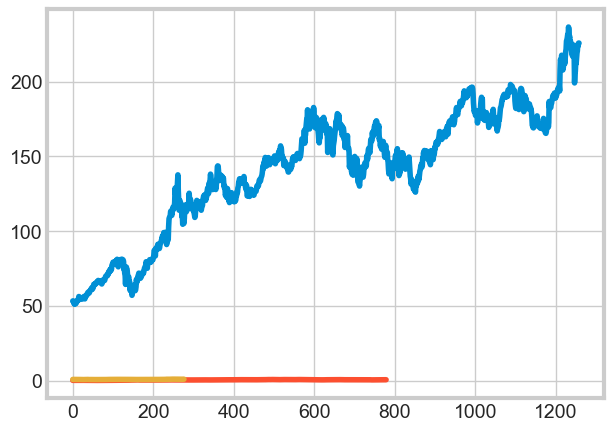

In [76]:
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict, label= 'train_predict')
plt.plot(test_predict, label = 'test_predict')
plt.legend

In [77]:
type(train_predict)

numpy.ndarray